# Sentiment Analysis using Deep Learning

  
**Dataset Source:** Hugging Face Datasets Library  
**Model Types:** LSTM (Binary Classification)

---

##  Background & Problem Statement

Sentiment analysis is a classic NLP task that involves classifying the sentiment of a text (e.g., product review, tweet, or comment) as positive, negative, or neutral. This task is valuable for understanding user opinions in business, politics, and customer feedback.

In this project, we aim to build and compare several deep learning models—RNN, LSTM, and GRU—for binary and multi-class sentiment classification using a publicly available dataset from Hugging Face.


In [1]:
!pip install -q datasets

##  Step 1: Downloading the Dataset

We use the `tafseer-nayeem/review_helpfulness_prediction` dataset from Hugging Face. It contains reviews labeled with helpfulness scores and sentiment, making it suitable for building and evaluating deep learning models for sentiment analysis.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Embedding,LSTM

from sklearn.model_selection import train_test_split

In [3]:
!pip install -q fsspec==2023.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" a

In [4]:
from datasets import load_dataset

dataset = load_dataset("tafseer-nayeem/review_helpfulness_prediction")

# Check the structure
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['user_review_posted', 'helpful_class', 'user_cities_visited', 'user_total_helpful_votes', 'review_text', 'review_days', 'expertise'],
        num_rows: 145381
    })
    validation: Dataset({
        features: ['user_review_posted', 'helpful_class', 'user_cities_visited', 'user_total_helpful_votes', 'review_text', 'review_days', 'expertise'],
        num_rows: 8080
    })
    test: Dataset({
        features: ['user_review_posted', 'helpful_class', 'user_cities_visited', 'user_total_helpful_votes', 'review_text', 'review_days', 'expertise'],
        num_rows: 8080
    })
})


##  Step 2: Exploratory Data Analysis (EDA)

Before modeling, we examine the dataset to understand its structure and class distribution.  
- We convert the training split to a Pandas DataFrame for easier inspection.  
- We view the dataset info, sample rows, and check the distribution of the target variable (`helpful_class`) to assess class balance.


In [5]:
import pandas as pd

# Convert to pandas for EDA
df_train = dataset['train'].to_pandas()

# Show structure
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145381 entries, 0 to 145380
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_review_posted        145381 non-null  int64  
 1   helpful_class             145381 non-null  int64  
 2   user_cities_visited       145381 non-null  int64  
 3   user_total_helpful_votes  145381 non-null  int64  
 4   review_text               145381 non-null  object 
 5   review_days               145381 non-null  float64
 6   expertise                 145381 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 7.8+ MB
None


In [ ]:
print(df_train.head())

   review_days  user_review_posted  helpful_class  \
0     0.514239                  36              1   
1     0.961117                   4              0   
2     0.606791                  65              0   
3     0.344469                  43              0   
4     0.570646                   2              0   

                                         review_text  expertise  \
0  The hotel is within walking distance of the Fo...   0.010813   
1  Stayed there a few times this summer.  As a fr...   0.002317   
2  I stayed here in 2011 great visit loved the lo...   0.001458   
3  Great service, big clean and comfortable rooms...   0.001019   
4  We stayed 3 nights at the Trump Hotel in DC.  ...   0.002317   

   user_cities_visited  user_total_helpful_votes  
0                   14                        81  
1                    1                         2  
2                   26                        21  
3                   20                        10  
4                    3 

In [ ]:
# Check label distribution
print(df_train['helpful_class'].value_counts())

helpful_class
0    91261
1    42574
2    10052
3     1288
4      206
Name: count, dtype: int64


In [ ]:
df_train.isnull().values.any()

np.False_

In [ ]:
df_train.shape

(145381, 7)

In [ ]:
df_train['review_text'][3]

"Great service, big clean and comfortable rooms, great bars and restaurants - and your on the BeachBest value for money I could find actually on the beach, I was a little worried that the location of the quality would not be as good as described but they were spot onWe had three rooms, 2 with partial ocean and one with an internal viewAll 3 were great rooms internally and couldn't be faulted - book early and the ocean views are god value for money - the lack of a view for our third room was a bit disappointing (all the rooms face the back of another building) but was as advertised - go for a sea view, its worth it"

Plot Label Distribution as Bar Chart

<ipython-input-11-a2c406a12315>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='helpful_class', data=df_train, palette='viridis')


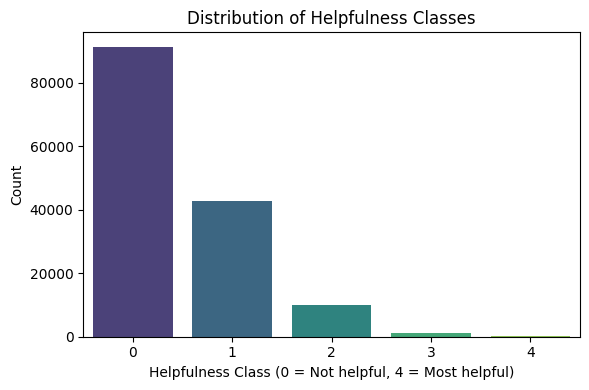

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='helpful_class', data=df_train, palette='viridis')

plt.title('Distribution of Helpfulness Classes')
plt.xlabel('Helpfulness Class (0 = Not helpful, 4 = Most helpful)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


##  Step 3: Text Cleaning and Preprocessing

To prepare our text data for sentiment modeling, we perform basic cleaning:

1. Removing html tags
2. Convert all text to lowercase
3. Remove punctuation and numeric characters
4. Retain stopwords – because we are using deep learning models (like LSTM, GRU, or Transformers), keeping stopwords is often beneficial. These models can learn contextual meanings, and removing stopwords like “not” may harm performance (e.g., "not good" vs. "good").

The cleaned text will be used for tokenization and embedding in later steps.



In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [7]:

import re

# Simple text preprocessing function
def clean_text(text):

    # Removing html tags
    text = remove_tags(text)

    text = text.lower()  # lowercase

    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation and numbers

    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    return text


cleaning on train set

In [8]:

# Apply to review_text
df_train['cleaned_text'] = df_train['review_text'].apply(clean_text)

# Show before and after
print(df_train[['review_text', 'cleaned_text']].head())



                                         review_text  \
0  The hotel is within walking distance of the Fo...   
1  Stayed there a few times this summer.  As a fr...   
2  I stayed here in 2011 great visit loved the lo...   
3  Great service, big clean and comfortable rooms...   
4  We stayed 3 nights at the Trump Hotel in DC.  ...   

                                        cleaned_text  
0  the hotel is within walking distance of the fo...  
1  stayed there few times this summer as frequent...  
2  i stayed here in great visit loved the locatio...  
3  great service big clean and comfortable rooms ...  
4  we stayed nights at the trump hotel in dc it w...  


cleaning on test set

In [9]:
# Convert to pandas for EDA
df_test = dataset['test'].to_pandas()

# Apply to review_text
df_test['cleaned_text'] = df_test['review_text'].apply(clean_text)

# Show before and after
print(df_test[['review_text', 'cleaned_text']].head())

                                         review_text  \
0  Despite being touted as a 5 star hotel, the Ka...   
1  Pros's:  This hotel is in a decent location (a...   
2  This is the worst hotel I’ve ever stayed in.  ...   
3  Across the street from waikiki beach, access t...   
4  My first impression of the Cosmo was good, but...   

                                        cleaned_text  
0  despite being touted as star hotel the kahala ...  
1  pross this hotel is in decent location at leas...  
2  this is the worst hotel ive ever stayed in im ...  
3  across the street from waikiki beach access to...  
4  my first impression of the cosmo was good but ...  


### Creating numerical labels from categorical values

class 0 = not helpfull is negative
class 1,2,3 = Positve

In [10]:
Labels = df_train['helpful_class']
# Convert labels to binary
Labels_train= np.array(list(map(lambda x: 1 if x > 0 else 0, Labels)))


In [11]:
Labels_test = np.array(list(map(lambda x: 1 if x > 0 else 0, df_test['helpful_class'])))


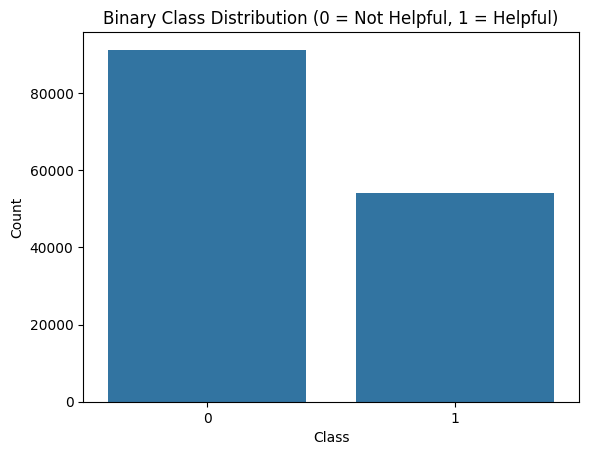

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df_train['binary_label'] = df_train['helpful_class'].apply(lambda x: 1 if x > 0 else 0)

Labels = df_train['helpful_class']
# Convert labels to binary
Labels_train= np.array(list(map(lambda x: 1 if x > 0 else 0, Labels)))

# Create a DataFrame for binary labels
binary_df = pd.DataFrame({'binary_label': Labels_train})

# Plot class distribution
sns.countplot(x='binary_label', data=binary_df)
plt.title("Binary Class Distribution (0 = Not Helpful, 1 = Helpful)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


##  Step 4: Tokenization and Sequence Padding

Neural networks cannot process raw text, so we convert our cleaned text into numerical format:

- **Tokenization**: Converts words into integer indices using a limited vocabulary (`vocab_size`).
- **Padding**: Ensures all sequences are the same length (`maxlen`) for efficient batching in model training.

We also define an out-of-vocabulary (OOV) token to handle rare or unseen words during inference.


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
maxlen = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])

X = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')
X_test = tokenizer.texts_to_sequences(df_test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

In [14]:
# Final training labels
y = np.array(df_train['binary_label'])

print("Input shape:", X.shape)
print("Label shape:", y.shape)


Input shape: (145381, 100)
Label shape: (145381,)


##  Step 5: Encode Labels (`helpful_class`)

Since this is a classification problem (predicting whether a review is helpful or not), we need to extract and prepare the labels:

- We check the unique values in the `helpful_class` column.
- If already encoded as binary values (e.g., 0 = not helpful, 1 = helpful), we can directly convert them into a NumPy array for training.


In [15]:
# Convert to binary: 1 = helpful (class > 0), 0 = not helpful (class == 0)
df_train['binary_label'] = df_train['helpful_class'].apply(lambda x: 1 if x > 0 else 0)

# Show unique binary labels
print("Unique binary labels:", df_train['binary_label'].unique())

# Encode as numpy array
binary_labels = np.array(df_train['binary_label'])

# Check shape and sample
print("Labels shape:", binary_labels.shape)
print("Sample:", binary_labels[:5])


Unique binary labels: [1 0]
Labels shape: (145381,)
Sample: [1 0 0 0 0]


##  Step 6: Build and Train the Models



### 6.1. Model1 : LSTM  (Binary Classification)

We build a simple yet effective **Sequential LSTM model** for binary classification of review helpfulness.

Model Architecture:
1. Embedding Layer
   - Converts input tokens into dense vector representations.  
   - Parameters: `input_dim=10000`, `output_dim=64`, `input_length=100`
2. LSTM Layer
   - Captures sequential dependencies in the review text.  
   - Includes `dropout` and `recurrent_dropout` to help prevent overfitting.
3. Dense Output Layer*  
   - Single neuron with `sigmoid` activation to output a probability between 0 and 1.

  Compilation Details:
- **Loss Function**: `binary_crossentropy`  
- **Optimizer**: `Adam` with learning rate `0.001`  
- **Evaluation Metric**: `accuracy`

 Training Configuration:
- **Epochs**: 5  
- **Batch Size**: 128  
- **Validation Split**: 20% of the training data is used for validation

This binary LSTM model provides a strong baseline for classifying whether a review is helpful or not.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))  # 1st layer - Embedding
model.add(LSTM(64, dropout=0.2))  # 2nd layer - LSTM
model.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.L2()))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # 3rd layer - Binary classification

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train model
history = model.fit(X, binary_labels, epochs=10, batch_size=128, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.6228 - loss: 0.8069 - val_accuracy: 0.6289 - val_loss: 0.6512
Epoch 2/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6248 - loss: 0.6524 - val_accuracy: 0.6289 - val_loss: 0.6479
Epoch 3/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6263 - loss: 0.6490 - val_accuracy: 0.6289 - val_loss: 0.6503
Epoch 4/10
909/909 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6295 - loss: 0.6445 - val_accuracy: 0.6289 - val_loss: 0.6515


### 6.2 LSTM with Pre-trained GloVe Embedding

In this model, we use GloVe (`glove.6B.50d`) — a set of pre-trained word vectors trained on a large corpus (Wikipedia + Gigaword). Instead of learning embeddings from scratch, we initialize the embedding layer with these meaningful word vectors.

####  Why Use GloVe?
- Transfers prior language knowledge into the model
- Helps generalize better on limited training data
- Captures semantic relationships between words (e.g., *“great”* ≈ *“excellent”*)

####  Model Architecture:
- **Embedding Layer** with pre-loaded GloVe weights (not trainable)
- **LSTM Layer** with 64 units
- **Dense Output Layer** with sigmoid activation for binary classification

####  Compilation:
- Loss: `binary_crossentropy`
- Optimizer: `Adam`
- Metric: `accuracy`

In [ ]:
import numpy as np

embedding_dim = 50  # using glove.6B.50d.txt

# Load GloVe vectors into a dictionary
embedding_index = {}
with open("glove.6B.50d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Loaded 400000 word vectors from GloVe.


Define and Train the GloVe + LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define GloVe-based LSTM model
model_glove = Sequential()
model_glove.add(Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=100,
                          trainable=False))  # freeze embeddings

model_glove.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_glove.add(Dense(1, activation='sigmoid'))

# Compile model
model_glove.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=['accuracy'])

# Train model
history_glove = model_glove.fit(X, binary_labels, epochs=5, batch_size=128, validation_split=0.2)


Epoch 1/5
909/909 [==============================] - 176s 191ms/step - loss: 0.6504 - accuracy: 0.6260 - val_loss: 0.6490 - val_accuracy: 0.6294
Epoch 2/5
909/909 [==============================] - 188s 206ms/step - loss: 0.6480 - accuracy: 0.6276 - val_loss: 0.6483 - val_accuracy: 0.6289
Epoch 3/5
909/909 [==============================] - 193s 212ms/step - loss: 0.6441 - accuracy: 0.6364 - val_loss: 0.6443 - val_accuracy: 0.6351
Epoch 4/5
909/909 [==============================] - 192s 211ms/step - loss: 0.6406 - accuracy: 0.6405 - val_loss: 0.6405 - val_accuracy: 0.6384
Epoch 5/5
909/909 [==============================] - 196s 216ms/step - loss: 0.6391 - accuracy: 0.6436 - val_loss: 0.6398 - val_accuracy: 0.6415


### 6.3 Model 3-  Regularized LSTM with SpatialDropout and L2

This model builds on the standard LSTM by introducing regularization techniques to prevent overfitting and enhance generalization. It uses **SpatialDropout1D**, **L2 weight regularization**, and an additional Dense layer.

####  Why Use This Model?
- **SpatialDropout1D** randomly drops entire word embeddings, making the model less dependent on specific words.
- **L2 regularization** penalizes large weights, helping reduce overfitting.
- A **hidden Dense layer** allows the model to learn more abstract features before classification.
- Now adapted for **binary classification**.

####  Model Architecture:
- **Embedding Layer**: Learns word embeddings from scratch
- **SpatialDropout1D**: Randomly drops word vectors to improve generalization
- **LSTM Layer**: 64 memory units with dropout and L2 regularization
- **Dense Layer**: 64 units with ReLU and L2 regularization
- **Output Layer**: 1 unit with `sigmoid` activation (for binary classification)

####  Compilation:
- **Loss**: `binary_crossentropy`
- **Optimizer**: `Adam` (learning rate = 0.001)
- **Metric**: `accuracy`

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

# Define binary classification model with regularization
model_reg = Sequential()
model_reg.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model_reg.add(SpatialDropout1D(0.3))
model_reg.add(LSTM(64, dropout=0.3, kernel_regularizer=L2(0.002)))
model_reg.add(Dense(64, activation='relu', kernel_regularizer=L2(0.002)))
model_reg.add(Dense(1, activation='sigmoid'))  # Changed from softmax to sigmoid ✅

# Compile for binary classification
model_reg.compile(loss='binary_crossentropy',  # Changed from categorical_crossentropy ✅
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Train the model
history_reg = model_reg.fit(X, binary_labels, epochs=15, batch_size=128, validation_split=0.2)


Epoch 1/15
909/909 [==============================] - 119s 129ms/step - loss: 0.6736 - accuracy: 0.6276 - val_loss: 0.6449 - val_accuracy: 0.6432
Epoch 2/15
909/909 [==============================] - 108s 119ms/step - loss: 0.6597 - accuracy: 0.6300 - val_loss: 0.6602 - val_accuracy: 0.6289
Epoch 3/15
909/909 [==============================] - 117s 129ms/step - loss: 0.6568 - accuracy: 0.6274 - val_loss: 0.6518 - val_accuracy: 0.6289
Epoch 4/15
909/909 [==============================] - 120s 132ms/step - loss: 0.6503 - accuracy: 0.6315 - val_loss: 0.6477 - val_accuracy: 0.6365
Epoch 5/15
909/909 [==============================] - 112s 123ms/step - loss: 0.6385 - accuracy: 0.6503 - val_loss: 0.6384 - val_accuracy: 0.6434
Epoch 6/15
909/909 [==============================] - 123s 135ms/step - loss: 0.6285 - accuracy: 0.6605 - val_loss: 0.6370 - val_accuracy: 0.6450
Epoch 7/15
909/909 [==============================] - 114s 126ms/step - loss: 0.6210 - accuracy: 0.6685 - val_loss: 0.6436 -

### 6.4 Model 4 – Bidirectional LSTM

The fourth model uses a Bidirectional LSTM architecture, which reads the input text sequences in both forward and backward directions. This helps the model understand the full context of a sentence — capturing both left-to-right and right-to-left dependencies. This is particularly useful for tasks like review classification, where important phrases can appear in any part of the text.

####  Architecture:
- Embedding layer with learned word representations
- Bidirectional LSTM with 64 units
- Output layer with sigmoid activation


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Build Bidirectional LSTM model
model_bi = Sequential()
model_bi.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model_bi.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bi.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bi.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=0.001),
                 metrics=['accuracy'])

# Train the model
history_bi = model_bi.fit(X, binary_labels, epochs=5, batch_size=128, validation_split=0.2)


Epoch 1/5
909/909 [==============================] - 723s 790ms/step - loss: 0.6401 - accuracy: 0.6407 - val_loss: 0.6321 - val_accuracy: 0.6500
Epoch 2/5
909/909 [==============================] - 716s 787ms/step - loss: 0.6199 - accuracy: 0.6653 - val_loss: 0.6366 - val_accuracy: 0.6431
Epoch 3/5
909/909 [==============================] - 719s 791ms/step - loss: 0.5991 - accuracy: 0.6865 - val_loss: 0.6515 - val_accuracy: 0.6474
Epoch 4/5
909/909 [==============================] - 696s 765ms/step - loss: 0.5726 - accuracy: 0.7079 - val_loss: 0.6640 - val_accuracy: 0.6380
Epoch 5/5
909/909 [==============================] - 699s 769ms/step - loss: 0.5427 - accuracy: 0.7319 - val_loss: 0.6928 - val_accuracy: 0.6221


### 6.5 Model 5 – LSTM with Fine-Tuned GloVe, Dropout, and Class Weights

This model extends the standard LSTM architecture by incorporating several key enhancements:
- **GloVe Embedding (100D)**: Used to initialize the embedding layer. Unlike previous models, this layer is set as **trainable**, allowing the model to fine-tune the word vectors.
- **Dropout Layers**: Dropout is applied after the LSTM and Dense layers to reduce overfitting.
- **Class Weights**: Used to address label imbalance and improve the model's sensitivity to the minority class (helpful reviews).
- **EarlyStopping**: Helps prevent overfitting by monitoring validation loss and restoring the best model weights.

#### Architecture:
- Embedding (pre-trained GloVe 100D, trainable)
- LSTM (64 units)
- Dropout(0.4)
- Dense(32, relu) + Dropout(0.3)
- Dense(1, sigmoid)

The model is compiled with the **Adam** optimizer and trained using **binary crossentropy** loss, with **class weighting and early stopping** for stability.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

# Step 1: Compute class weights using binary_labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(binary_labels),
    y=binary_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Step 2: Define the model
model_lstm_glove_reg = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=maxlen, trainable=True),
    LSTM(64),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Step 3: Compile the model
model_lstm_glove_reg.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Step 4: Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Step 5: Train the model
history_lstm_glove_reg = model_lstm_glove_reg.fit(
    X, binary_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Class weights: {0: 0.7965122012688881, 1: 1.3431356245380635}
Epoch 1/10
1818/1818 [==============================] - 136s 74ms/step - loss: 0.6833 - accuracy: 0.5718 - val_loss: 0.6770 - val_accuracy: 0.5704
Epoch 2/10
1818/1818 [==============================] - 140s 77ms/step - loss: 0.6810 - accuracy: 0.5767 - val_loss: 0.6793 - val_accuracy: 0.5714
Epoch 3/10
1818/1818 [==============================] - 144s 79ms/step - loss: 0.6694 - accuracy: 0.6039 - val_loss: 0.6607 - val_accuracy: 0.6237
Epoch 4/10
1818/1818 [==============================] - 140s 77ms/step - loss: 0.6554 - accuracy: 0.6322 - val_loss: 0.6600 - val_accuracy: 0.6220
Epoch 5/10
1818/1818 [==============================] - 137s 75ms/step - loss: 0.6408 - accuracy: 0.6537 - val_loss: 0.6625 - val_accuracy: 0.6123
Epoch 6/10
1818/1818 [==============================] - 129s 71ms/step - loss: 0.6259 - accuracy: 0.6703 - val_loss: 0.6833 - val_accuracy: 0.6049


### 6.6 Model 6 – CNN for Text Classification

This model uses a 1D Convolutional Neural Network (CNN) to classify reviews as helpful or not helpful. CNNs are highly effective for capturing local n-gram patterns (e.g., phrases like "not helpful", "very useful") regardless of their position in the text.

Unlike LSTM models that process sequences step-by-step, CNNs apply filters across the text in parallel, making them faster to train while still achieving strong performance.

#### Architecture:
- **Embedding Layer**: Initialized with pre-trained GloVe 100D embeddings (trainable)
- **Conv1D Layer**: 128 filters, kernel size 5, ReLU activation
- **GlobalMaxPooling1D**: Reduces the output to the most prominent feature across time steps
- **Dense Layer**: 64 units with ReLU
- **Dropout**: 0.5 for regularization
- **Output Layer**: 1 neuron with sigmoid activation for binary classification

The model was compiled using binary crossentropy loss and trained with early stopping and class weights to handle data imbalance.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import numpy as np

# Step 1: Recalculate class weights using binary_labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(binary_labels),
    y=binary_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Step 2: Define CNN model
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=maxlen, trainable=True),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Step 3: Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Step 5: Train the model
cnn_history = cnn_model.fit(
    X, binary_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Class weights: {0: 0.7965122012688881, 1: 1.3431356245380635}
Epoch 1/10
1818/1818 [==============================] - 28s 15ms/step - loss: 0.6821 - accuracy: 0.5797 - val_loss: 0.6651 - val_accuracy: 0.6226
Epoch 2/10
1818/1818 [==============================] - 28s 15ms/step - loss: 0.6680 - accuracy: 0.6134 - val_loss: 0.6616 - val_accuracy: 0.6135
Epoch 3/10
1818/1818 [==============================] - 27s 15ms/step - loss: 0.6543 - accuracy: 0.6376 - val_loss: 0.6659 - val_accuracy: 0.6198
Epoch 4/10
1818/1818 [==============================] - 27s 15ms/step - loss: 0.6351 - accuracy: 0.6631 - val_loss: 0.6743 - val_accuracy: 0.6182


### 6.7 Model 7 – Transformer (BERT) for Text Classification

This model leverages the **BERT-base-uncased** transformer architecture from Hugging Face, which excels at capturing deep contextual relationships in language. Unlike traditional RNNs or CNNs, BERT processes entire sequences at once using attention mechanisms, allowing it to model long-range dependencies and nuanced meanings effectively.

BERT brings the power of transfer learning by using pre-trained knowledge from large corpora (Wikipedia + BooksCorpus), which helps generalize better, especially on smaller datasets.

#### Architecture:
- Pretrained BERT Base Encoder: bert-base-uncased loaded from Hugging Face (TFBertModel)
-** Dropout Layer 1**: Dropout rate of 0.3 to prevent overfitting
- **Dense Layer**: 64 units with ReLU activation for nonlinear transformation
- **Dropout Layer 2**: Dropout rate of 0.2 for additional regularization
- **Output Layer**: 1 neuron with sigmoid activation for binary classification (helpful vs not helpful)

Loss Function: Binary crossentropy / Optimizer: Adam with a learning rate of 2e-5

The model uses the pooled output ([CLS] token embedding) from BERT, applies regularization and a dense layer, and then predicts a binary label using sigmoid activation.



In [ ]:
!pip install -q transformers


In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizerFast
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# train_encodings = tokenizer(
#     df_train['cleaned_text'].tolist(),
#     truncation=True,
#     padding="max_length",
#     max_length=100,
# )

MAX_LEN = 100
BATCH_SIZE = 64

def tokenize(texts, labels, max_len=100):
  encodings = bert_tokenizer(
      texts,
      truncation=True,
      padding='max_length',
      max_length=max_len,
  )
  return tf.data.Dataset.from_tensor_slices(({
      "input_ids": encodings["input_ids"],
      "attention_mask": encodings["attention_mask"]
    }, labels))

# Create train and val datasets
total_train_samples = len(df_train)
validation_split = 0.1
num_validation_samples = int(total_train_samples * validation_split)

bert_train_val_ds = tokenize(df_train["cleaned_text"].tolist(), Labels_train, max_len=MAX_LEN).shuffle(buffer_size=1024)
bert_train_ds = bert_train_val_ds.skip(num_validation_samples).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
bert_val_ds = bert_train_val_ds.take(num_validation_samples).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
class BertClassifier(tf.keras.Model):
    def __init__(self, dropout_rate=0.3):
        super(BertClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")
        self.dropout1 = Dropout(dropout_rate)
        self.dense = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.out = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        bert_outputs = self.bert(inputs)
        pooled_output = bert_outputs.pooler_output
        x = self.dropout1(pooled_output, training=training)
        x = self.dense(x)
        x = self.dropout2(x, training=training)
        return self.out(x)


In [ ]:
BERT_model = BertClassifier()
BERT_model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
with tf.device('/device:GPU:0'):

  BERT_history=BERT_model.fit(
      bert_train_ds,
      validation_data=bert_val_ds,
      batch_size=32,
      class_weight=class_weights,
      epochs=5,
      callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
  )


Epoch 1/5
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 790s 188ms/step - accuracy: 0.6017 - loss: 0.6786 - val_accuracy: 0.6259 - val_loss: 0.6605
Epoch 2/5
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 755s 185ms/step - accuracy: 0.6276 - loss: 0.6598 - val_accuracy: 0.6259 - val_loss: 0.6593
Epoch 3/5
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 757s 185ms/step - accuracy: 0.6273 - loss: 0.6585 - val_accuracy: 0.6259 - val_loss: 0.6576
Epoch 4/5
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 759s 186ms/step - accuracy: 0.6279 - loss: 0.6572 - val_accuracy: 0.6259 - val_loss: 0.6564
Epoch 5/5
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 761s 186ms/step - accuracy: 0.6280 - loss: 0.6565 - val_accuracy: 0.6259 - val_loss: 0.6561


### 6.8 Model 8 – Fine-Tuned BERT with Class Weights

In this version, we fine-tuned the pretrained `bert-base-uncased` model using class weighting to address label imbalance between “Helpful” and “Not Helpful” reviews. This helped improve the model’s attention to minority class samples and encouraged more balanced learning.

This model is based on the same architecture as Model 7, with additional optimization through class weighting and slightly increased epochs.

#### Architecture:
- **Pretrained BERT Base Encoder**: `bert-base-uncased` (`TFBertModel`)
- **Dropout Layer 1**: 0.3 for regularization
- **Dense Layer**: 64 units, ReLU activation
- **Dropout Layer 2**: 0.2
- **Output Layer**: 1 unit with Sigmoid activation (binary classification)
- **Loss Function**: Binary Crossentropy
- **Optimizer**: Adam (learning rate = 2e-5)
- **Training Add-on**: `class_weight` computed using `sklearn.utils.compute_class_weight`
- **Epochs**: 4
- **Validation Split**: 10%

By incorporating class weights during training, the model was encouraged to reduce bias toward the majority class ("Not Helpful") and achieve better precision/recall balance for both classes.


In [ ]:
# Step 1: Imports
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# Step 2: Define custom model class
class BertClassifier(tf.keras.Model):
    def __init__(self, dropout_rate=0.3):
        super(BertClassifier, self).__init__()
        self.bert = TFBertModel.from_pretrained("bert-base-uncased")
        self.dropout1 = Dropout(dropout_rate)
        self.dense = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.out = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        bert_outputs = self.bert(inputs)
        pooled_output = bert_outputs.pooler_output
        x = self.dropout1(pooled_output, training=training)
        x = self.dense(x)
        x = self.dropout2(x, training=training)
        return self.out(x)

In [ ]:
# Step 3: Initialize and compile the model
bert_weighted_model = BertClassifier()
bert_weighted_model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 4: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Labels_train),
    y=Labels_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Step 5: Train the model with class weights
history_bert8 = bert_weighted_model.fit(
    x={
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y=Labels_train,
    validation_split=0.1,
    batch_size=64,
    epochs=4,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)],
    shuffle=True
)


### 6.9 Model 9 – Improved Fine-Tuned DistilBERT Classifier


In [ ]:
# Step 1: Imports
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizerFast
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay


In [ ]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

MAX_LEN = 100
BATCH_SIZE = 64

def tokenize(texts, labels, max_len=100):
  encodings = distilbert_tokenizer(
      texts,
      truncation=True,
      padding='max_length',
      max_length=max_len,
  )
  return tf.data.Dataset.from_tensor_slices(({
      "input_ids": encodings["input_ids"],
      "attention_mask": encodings["attention_mask"]
    }, labels))

# Create train and val datasets
total_train_samples = len(df_train)
validation_split = 0.1
num_validation_samples = int(total_train_samples * validation_split)

distilbert_train_val_ds = tokenize(df_train["cleaned_text"].tolist(), Labels_train, max_len=MAX_LEN).shuffle(buffer_size=1024)
distilbert_train_ds = distilbert_train_val_ds.skip(num_validation_samples).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
distilbert_val_ds = distilbert_train_val_ds.take(num_validation_samples).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Step 2: Define improved custom model class
class DistilBertClassifier(tf.keras.Model):
    def __init__(self, dropout_rate=0.3):
        super(DistilBertClassifier, self).__init__()
        self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout1 = Dropout(dropout_rate)
        self.dense1 = Dense(128, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense2 = Dense(64, activation='relu')
        self.out = Dense(1, activation='sigmoid')  # binary classification

    def call(self, inputs, training=False):
        bert_outputs = self.bert(inputs)
        pooled_output = bert_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        x = self.dropout1(pooled_output, training=training)
        x = self.dense1(x)
        x = self.dropout2(x, training=training)
        x = self.dense2(x)
        return self.out(x)

In [ ]:
# Step 3: Learning rate schedule + optimizer
epochs = 5
steps_per_epoch = total_train_samples // BATCH_SIZE
total_training_steps = steps_per_epoch * epochs

lr_schedule = PolynomialDecay(
    initial_learning_rate=2e-3,
    decay_steps=total_training_steps,
    end_learning_rate=1e-6
)
optimizer = Adam(learning_rate=lr_schedule)

In [ ]:
# Step 4: Initialize and compile the model
distilbert_weighted_model = DistilBertClassifier()
distilbert_weighted_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 5: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Labels_train),
    y=Labels_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Step 6: Train the model

with tf.device('/device:GPU:0'):
  history_bert9 = distilbert_weighted_model.fit(
      distilbert_train_ds,
      validation_data=distilbert_val_ds,
      batch_size=BATCH_SIZE,
      epochs=5,
      class_weight=class_weight_dict,
      callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True), tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6, verbose=1)],
  )


Epoch 1/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 391s 186ms/step - accuracy: 0.5586 - loss: 0.6869 - val_accuracy: 0.5635 - val_loss: 0.6876 - learning_rate: 0.0016
Epoch 2/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 372s 182ms/step - accuracy: 0.5855 - loss: 0.6757 - val_accuracy: 0.5573 - val_loss: 0.6877 - learning_rate: 0.0013
Epoch 3/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 386s 184ms/step - accuracy: 0.5891 - loss: 0.6743 - val_accuracy: 0.5764 - val_loss: 0.6814 - learning_rate: 9.1996e-04
Epoch 4/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 373s 182ms/step - accuracy: 0.5918 - loss: 0.6725 - val_accuracy: 0.5751 - val_loss: 0.6793 - learning_rate: 5.5995e-04
Epoch 5/5
2045/2045 ━━━━━━━━━━━━━━━━━━━━ 381s 182ms/step - accuracy: 0.5957 - loss: 0.6712 - val_accuracy: 0.6007 - val_loss: 0.6730 - learning_rate: 1.9993e-04


##  Step 7: Model Evaluation – Accuracy and Loss


###7.1. Model1 : LSTM  (Binary Classification)
After training the LSTM model, we visualize the training and validation performance:

- **Accuracy Plot**: Shows how well the model is learning to classify the reviews correctly over each epoch.
- **Loss Plot**: Helps identify underfitting or overfitting by comparing training and validation loss.

These plots help visualize the effectiveness of our model architecture and training settings.

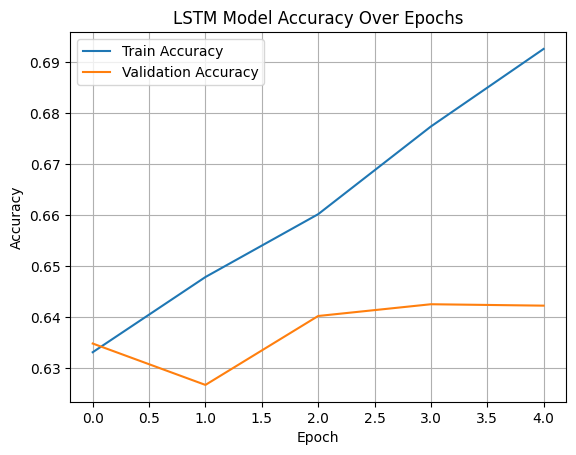

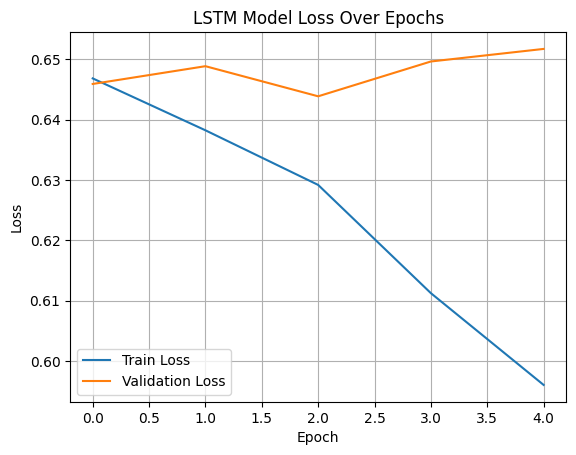

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.2 Model 2 : GloVe LSTM – Accuracy and Loss Plot

We visualize the training performance of the GloVe-based LSTM model to better understand its learning behavior.

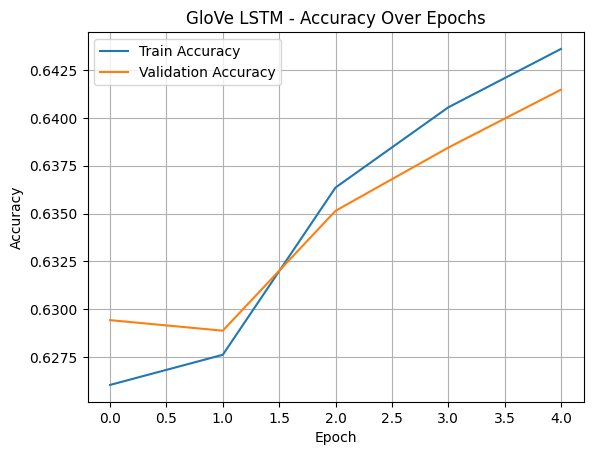

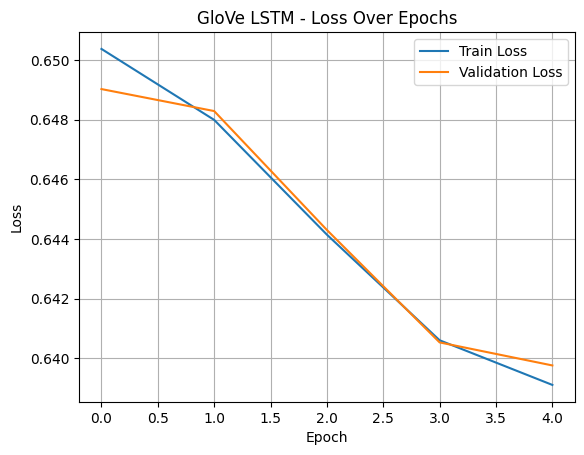

In [ ]:
plt.plot(history_glove.history['accuracy'], label='Train Accuracy')
plt.plot(history_glove.history['val_accuracy'], label='Validation Accuracy')
plt.title('GloVe LSTM - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history_glove.history['loss'], label='Train Loss')
plt.plot(history_glove.history['val_loss'], label='Validation Loss')
plt.title('GloVe LSTM - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

###  7.3 Model 3 - Regularized LSTM – Accuracy and Loss Plot

We visualize the training progress of the regularized LSTM model, which includes **SpatialDropout**, **L2 regularization**, and a hidden Dense layer.

These plots help us assess whether the model is learning well over time and whether it's at risk of overfitting.

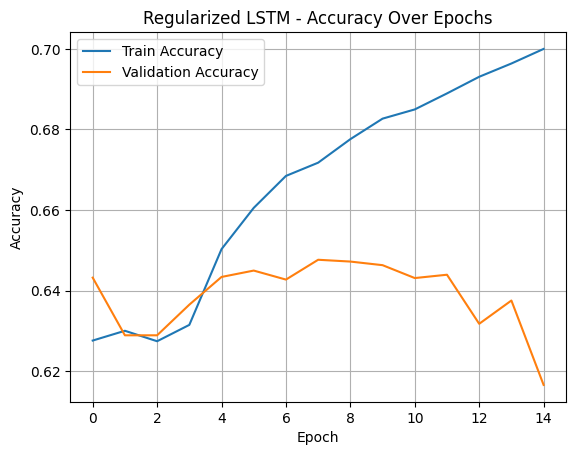

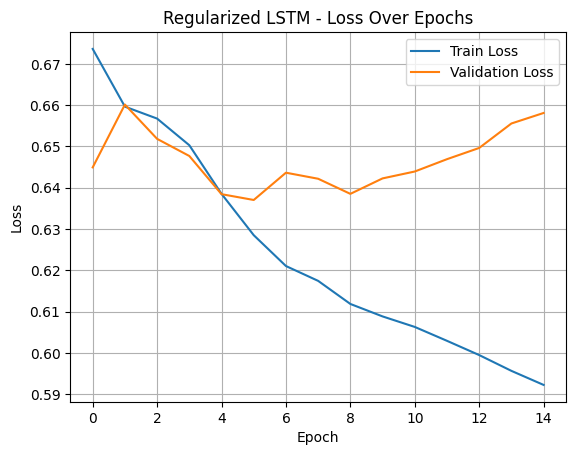

In [ ]:
# Accuracy plot
plt.plot(history_reg.history['accuracy'], label='Train Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Regularized LSTM - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history_reg.history['loss'], label='Train Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Regularized LSTM - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 7.4 Model 4 - Bidirectional LSTM – Accuracy and Loss Plot
After training, the model’s accuracy and loss curves were visualized to assess training stability and generalization.

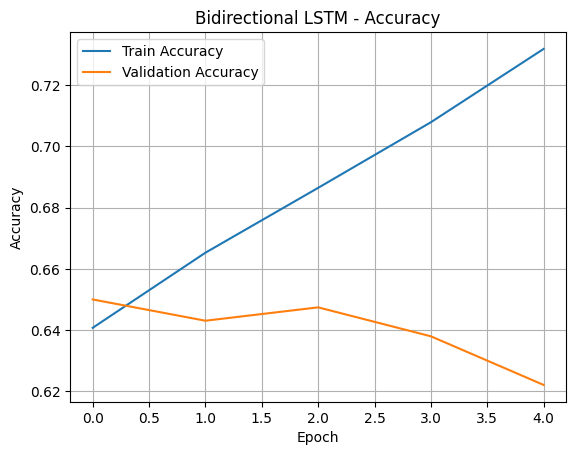

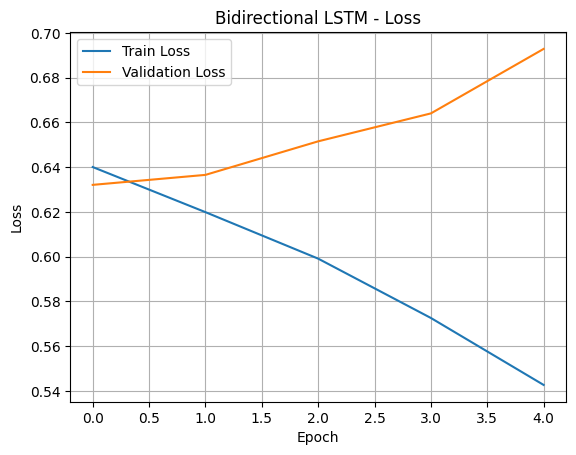

In [ ]:
# Plot accuracy
plt.plot(history_bi.history['accuracy'], label='Train Accuracy')
plt.plot(history_bi.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history_bi.history['loss'], label='Train Loss')
plt.plot(history_bi.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.5 Model 5 – LSTM with Fine-Tuned GloVe, Dropout, and Class Weights - Accuracy and Loss Plot

The training and validation accuracy/loss curves for Model 5 are visualized below. This model used fine-tuned GloVe embeddings, dropout layers, class weights, and early stopping to improve generalization and prevent overfitting.

By monitoring the validation loss, the model automatically stopped training when further improvement plateaued, helping it converge efficiently while avoiding unnecessary epochs.


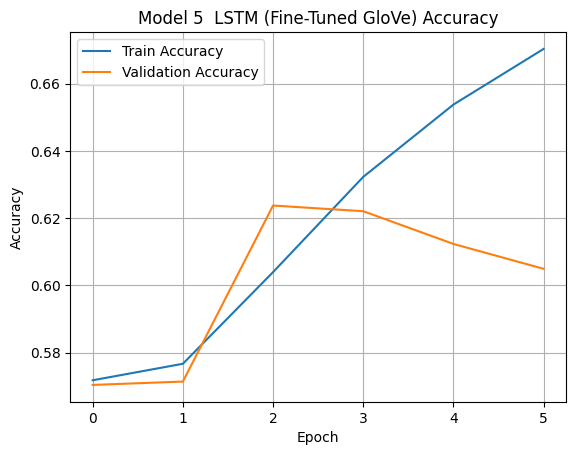

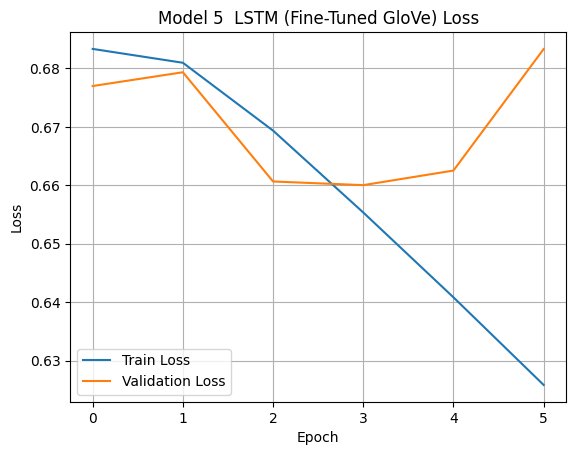

In [ ]:
# Plot Accuracy
plt.plot(history_lstm_glove_reg.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_glove_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 5  LSTM (Fine-Tuned GloVe) Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history_lstm_glove_reg.history['loss'], label='Train Loss')
plt.plot(history_lstm_glove_reg.history['val_loss'], label='Validation Loss')
plt.title('Model 5  LSTM (Fine-Tuned GloVe) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.6 Model 6 – Accuracy and Loss Plot

The CNN model was trained for up to 10 epochs using early stopping and class weighting to manage label imbalance. Below are the training and validation accuracy and loss plots.

CNNs are typically faster to train than LSTMs and can effectively detect key n-gram patterns in text that are predictive of helpfulness. These plots help visualize how well the model generalizes during training.


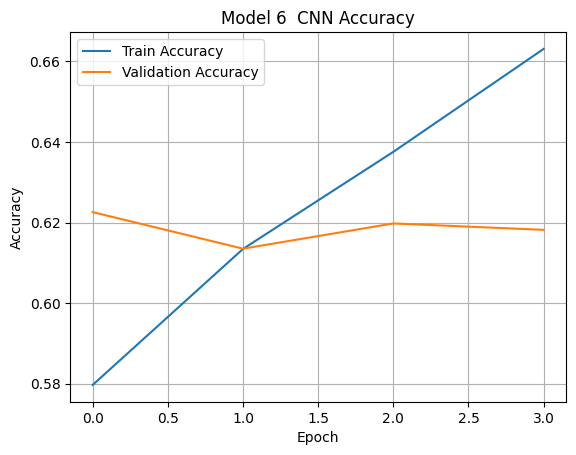

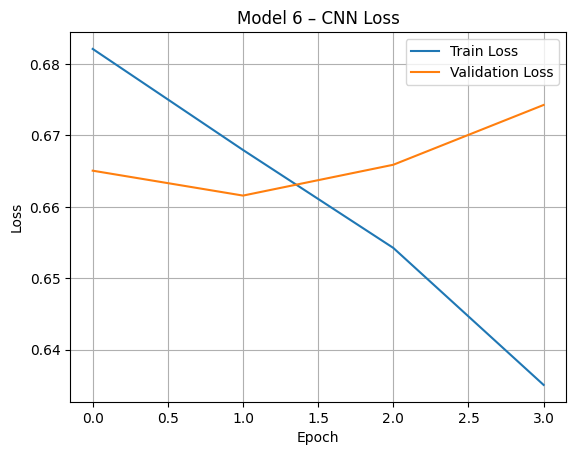

In [ ]:
# Plot accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 6  CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model 6 – CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.7 Model 7 – Accuracy and Loss Plot




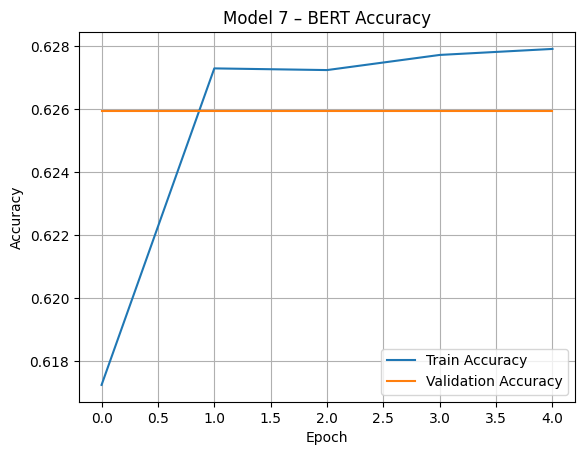

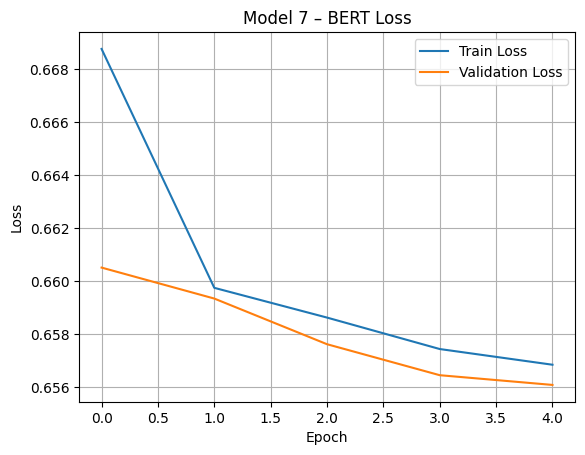

In [ ]:
# Plot accuracy
plt.plot(BERT_history.history['accuracy'], label='Train Accuracy')
plt.plot(BERT_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 7 – BERT Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(BERT_history.history['loss'], label='Train Loss')
plt.plot(BERT_history.history['val_loss'], label='Validation Loss')
plt.title('Model 7 – BERT Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.8 Model 8 – Accuracy and Loss Plot


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_bert8.history['accuracy'], label='Train Accuracy')
plt.plot(history_bert8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 8 – BERT with Class Weights Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history_bert8.history['loss'], label='Train Loss')
plt.plot(history_bert8.history['val_loss'], label='Validation Loss')
plt.title('Model 8 – BERT with Class Weights Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 7.9 Model 9 – Accuracy and Loss Plot


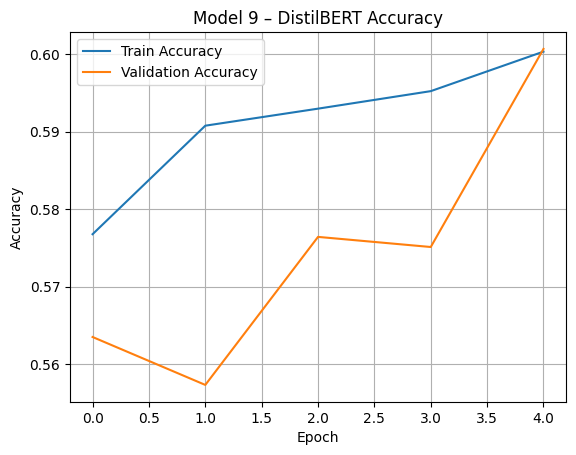

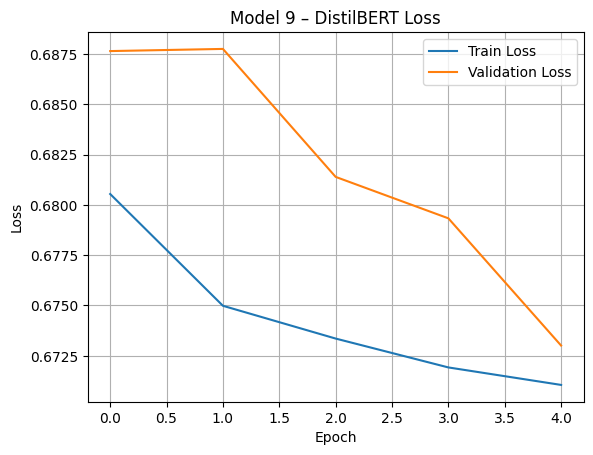

In [ ]:
# Plot accuracy
plt.plot(history_bert9.history['accuracy'], label='Train Accuracy')
plt.plot(history_bert9.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 9 – DistilBERT Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Plot loss
plt.plot(history_bert9.history['loss'], label='Train Loss')
plt.plot(history_bert9.history['val_loss'], label='Validation Loss')
plt.title('Model 9 – DistilBERT Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


###  Observations



##  Step 8: Final Evaluation - Evaluate the Model on the Test Set

After training and validating our model, we now evaluate its performance on the **unseen test data**.

Load and Preprocess the Test Set

We follow the exact same preprocessing steps used on the training data:
- Convert the test set to a Pandas DataFrame
- Apply the same text cleaning function
- Tokenize and pad the `cleaned_text` using the trained tokenizer
- One-hot encode the `helpful_class` labels for multi-class evaluation


In [ ]:
# Clean the test reviews
df_test['cleaned_text'] = df_test['review_text'].apply(clean_text)

# Convert to sequences
test_sequences = tokenizer.texts_to_sequences(df_test['cleaned_text'])
X_test = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

# Convert test labels to binary
y_test = np.array(df_test['helpful_class'].apply(lambda x: 1 if x > 0 else 0))



### Step 8.1: Model 1 evaluation - Evaluate LSTM on the Test Set

We now use the trained LSTM model to evaluate performance on the test set.  
This step provides an unbiased estimate of how well the model generalizes to new data.

The model returns:
- **Test Accuracy**: Percentage of correctly predicted labels
- **Test Loss**: Final loss value (categorical cross-entropy)


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

253/253 [==============================] - 3s 11ms/step - loss: 0.6485 - accuracy: 0.6458
Test Accuracy: 0.6458
Test Loss: 0.6485


###  8.2 Model 2 Evaluation - Evaluate GloVe LSTM on the Test Set

After training, we evaluate the GloVe-based LSTM model using the test set to measure generalization performance.


In [ ]:
# Evaluate the model
loss_glove, acc_glove = model_glove.evaluate(X_test, y_test)
print(f"GloVe LSTM Test Accuracy: {acc_glove:.4f}")
print(f"GloVe LSTM Test Loss: {loss_glove:.4f}")

253/253 [==============================] - 3s 11ms/step - loss: 0.6384 - accuracy: 0.6470
GloVe LSTM Test Accuracy: 0.6470
GloVe LSTM Test Loss: 0.6384


### 8.3 Model 3 Evaluation - Evaluate Regularized LSTM on the Test Set

In this step, we evaluate the performance of the regularized LSTM model on unseen test data. This helps us understand the model’s generalization capabilities beyond the training and validation data.


In [ ]:
# Evaluate the regularized LSTM model on the test set
loss_reg, acc_reg = model_reg.evaluate(X_test, y_test)
print(f"Regularized LSTM Test Accuracy: {acc_reg:.4f}")
print(f"Regularized LSTM Test Loss: {loss_reg:.4f}")

253/253 [==============================] - 4s 14ms/step - loss: 0.6570 - accuracy: 0.6224
Regularized LSTM Test Accuracy: 0.6224
Regularized LSTM Test Loss: 0.6570


### 8.4 Model 4 Evaluation - Evaluate Bidirectional LSTM on Test Set

In [ ]:
# Evaluate on test set
loss_bi, acc_bi = model_bi.evaluate(X_test, y_test)
print(f"Bidirectional LSTM Test Accuracy: {acc_bi:.4f}")
print(f"Bidirectional LSTM Test Loss: {loss_bi:.4f}")


253/253 [==============================] - 3s 12ms/step - loss: 0.6928 - accuracy: 0.6243
Bidirectional LSTM Test Accuracy: 0.6243
Bidirectional LSTM Test Loss: 0.6928


### 8.5 Model 5 Evaluation – Evaluate LSTM with Fine-Tuned GloVe, Dropout, and Class Weights

Model 5 was evaluated using the held-out test set. The evaluation includes:

The use of fine-tuned GloVe embeddings, dropout layers, and class weighting helped improve the model’s robustness and sensitivity to the minority class.


In [ ]:
# Evaluate on test set
loss_lstm5, acc_lstm5 = model_lstm_glove_reg.evaluate(X_test, y_test)
print(f"LSTM (Fine-Tuned GloVe) Test Accuracy: {acc_lstm5:.4f}")
print(f"LSTM (Fine-Tuned GloVe) Test Loss: {loss_lstm5:.4f}")


253/253 [==============================] - 5s 18ms/step - loss: 0.6612 - accuracy: 0.6153
LSTM (Fine-Tuned GloVe) Test Accuracy: 0.6153
LSTM (Fine-Tuned GloVe) Test Loss: 0.6612


### 8.6 Model 6 – Test Set Evaluation

The CNN model was evaluated on the test set to assess its final performance. The results below include overall test accuracy and loss.

CNNs can capture important local patterns in text and often perform competitively with LSTM-based models while training more efficiently.


In [ ]:
# Evaluate on test set
loss_cnn, acc_cnn = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Accuracy: {acc_cnn:.4f}")
print(f"CNN Test Loss: {loss_cnn:.4f}")


253/253 [==============================] - 1s 3ms/step - loss: 0.6624 - accuracy: 0.6129
CNN Test Accuracy: 0.6129
CNN Test Loss: 0.6624


### 8.7 Model 7 – Test Set Evaluation



In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

MAX_LEN = 100
BATCH_SIZE = 64

def tokenize(texts, labels, max_len=100):
  encodings = bert_tokenizer(
      texts,
      truncation=True,
      padding='max_length',
      max_length=max_len,
  )
  return tf.data.Dataset.from_tensor_slices(({
      "input_ids": encodings["input_ids"],
      "attention_mask": encodings["attention_mask"]
    }, labels))

test_dataset = tokenize(df_test['cleaned_text'].tolist(), Labels_test, max_len=MAX_LEN).batch(BATCH_SIZE)

In [ ]:
# Evaluate on test set
loss_bert, acc_bert = BERT_model.evaluate(test_dataset)

print(f"BERT Test Accuracy: {acc_bert:.4f}")
print(f"BERT Test Loss: {loss_bert:.4f}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 328ms/step - accuracy: 0.6292 - loss: 0.6515
BERT Test Accuracy: 0.6276
BERT Test Loss: 0.6538


### 8.8 Model 8 – Test Set Evaluation


In [ ]:
test_encodings = tokenizer(
    list(df_test['cleaned_text']),
    truncation=True,
    padding=True,
    max_length=100,
    return_tensors='tf'
)

Labels_test = np.array([1 if x > 0 else 0 for x in df_test['helpful_class']])


In [ ]:
# Evaluate on test set
test_loss, test_acc = bert_weighted_model.evaluate(
    x={
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    y=Labels_test
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


253/253 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.5854 - loss: 0.6854
Test Accuracy: 0.5712
Test Loss: 0.6875


### 8.9 Model 9 – Test Set Evaluation


In [ ]:
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

MAX_LEN = 100
BATCH_SIZE = 64

def tokenize(texts, labels, max_len=100):
  encodings = distilbert_tokenizer(
      texts,
      truncation=True,
      padding='max_length',
      max_length=max_len,
  )
  return tf.data.Dataset.from_tensor_slices(({
      "input_ids": encodings["input_ids"],
      "attention_mask": encodings["attention_mask"]
    }, labels))

distilbert_test_ds = tokenize(df_test['cleaned_text'].tolist(), Labels_test, max_len=MAX_LEN).batch(BATCH_SIZE)

In [ ]:
# Evaluate on test set
test_loss_bert9, test_acc_bert9 = distilbert_weighted_model.evaluate(distilbert_test_ds)

print(f"Model 9 – DistilBERT Test Accuracy: {test_acc_bert9:.4f}")
print(f"Model 9 – DistilBERT Test Loss: {test_loss_bert9:.4f}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.6213 - loss: 0.6670
Model 9 – DistilBERT Test Accuracy: 0.6147
Model 9 – DistilBERT Test Loss: 0.6701


##  Step 9: Confusion Matrix & Classification Report

While overall accuracy provides a general sense of model performance, it doesn’t show how well the model performs on each individual class. For that, we evaluate:

- **Confusion Matrix**: Displays true vs. predicted classifications.
- **Classification Report**: Provides metrics such as precision, recall, and F1-score for each class (0 = Not Helpful, 1 = Helpful)



### Step 9.1: Model 1 - LSTM Confusion Matrix & Classification Report

We use `model.predict()` on the padded test set, then convert the predicted probabilities and true labels into class indices for comparison.

253/253 [==============================] - 3s 11ms/step


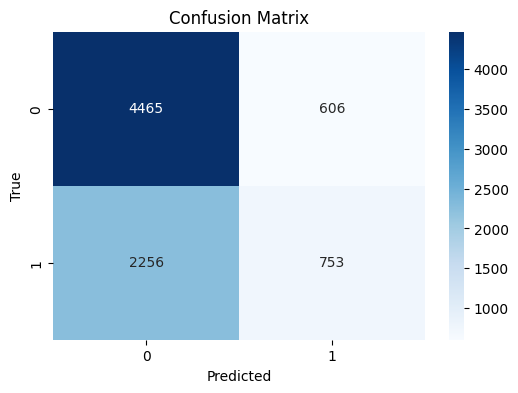

              precision    recall  f1-score   support

 Not Helpful       0.66      0.88      0.76      5071
     Helpful       0.55      0.25      0.34      3009

    accuracy                           0.65      8080
   macro avg       0.61      0.57      0.55      8080
weighted avg       0.62      0.65      0.60      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Not Helpful', 'Helpful']))

###  9.2 Model 2 - GloVe LSTM – Confusion Matrix & Classification Report

To evaluate how well the GloVe-based LSTM model performs across both classes (0 = Not Helpful, 1 = Helpful), we analyze:

- **Confusion Matrix**: True vs. predicted label counts
- **Classification Report**: Precision, recall, and F1-score for each class


253/253 [==============================] - 3s 11ms/step


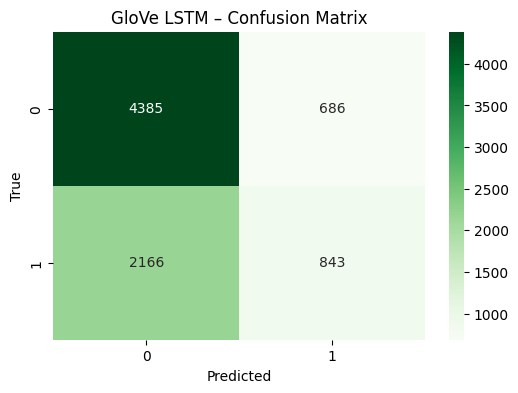

              precision    recall  f1-score   support

 Not Helpful       0.67      0.86      0.75      5071
     Helpful       0.55      0.28      0.37      3009

    accuracy                           0.65      8080
   macro avg       0.61      0.57      0.56      8080
weighted avg       0.63      0.65      0.61      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels on test data
y_pred_probs_glove = model_glove.predict(X_test)
y_pred_glove = (y_pred_probs_glove > 0.5).astype(int).flatten()

# Confusion matrix
cm_glove = confusion_matrix(y_test, y_pred_glove)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GloVe LSTM – Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_glove, target_names=['Not Helpful', 'Helpful']))

###  9.3 Model 3 – Regularized LSTM – Confusion Matrix & Classification Report

To evaluate how well the Regularized LSTM model performs on the binary classification task (0 = Not Helpful, 1 = Helpful), we generated the following:

- **Confusion Matrix**: Shows how many helpful and non-helpful reviews were correctly and incorrectly classified.
- **Classification Report**: Includes precision, recall, and F1-score for each class.

The Regularized LSTM architecture includes SpatialDropout and L2 regularization to reduce overfitting. This model balances both accuracy and generalization, making it suitable for longer training durations.

253/253 [==============================] - 4s 14ms/step


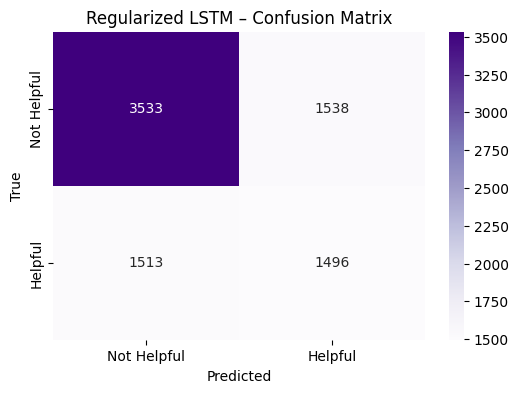

              precision    recall  f1-score   support

 Not Helpful       0.70      0.70      0.70      5071
     Helpful       0.49      0.50      0.50      3009

    accuracy                           0.62      8080
   macro avg       0.60      0.60      0.60      8080
weighted avg       0.62      0.62      0.62      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict probabilities
y_pred_probs_reg = model_reg.predict(X_test)

# Step 2: Convert probabilities to binary predictions
y_pred_reg = (y_pred_probs_reg > 0.5).astype(int).flatten()

# Step 3: Generate confusion matrix
cm_reg = confusion_matrix(y_test, y_pred_reg)

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_reg, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Helpful', 'Helpful'], yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Regularized LSTM – Confusion Matrix')
plt.show()

# Step 5: Print classification report
print(classification_report(y_test, y_pred_reg, target_names=['Not Helpful', 'Helpful']))


### 9.4 Confusion Matrix & Classification Report – Bidirectional LSTM

253/253 [==============================] - 3s 12ms/step


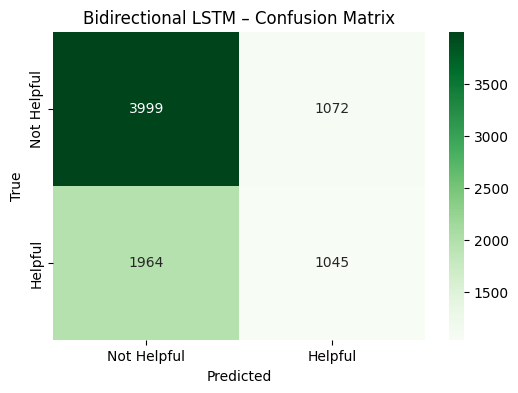

              precision    recall  f1-score   support

 Not Helpful       0.67      0.79      0.72      5071
     Helpful       0.49      0.35      0.41      3009

    accuracy                           0.62      8080
   macro avg       0.58      0.57      0.57      8080
weighted avg       0.60      0.62      0.61      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred_probs_bi = model_bi.predict(X_test)
y_pred_bi = (y_pred_probs_bi > 0.5).astype(int).flatten()

# Confusion matrix
cm_bi = confusion_matrix(y_test, y_pred_bi)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bi, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Helpful', 'Helpful'], yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional LSTM – Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_bi, target_names=['Not Helpful', 'Helpful']))


### 9.5 Model 5 – Confusion Matrix & Classification Report


253/253 [==============================] - 5s 17ms/step


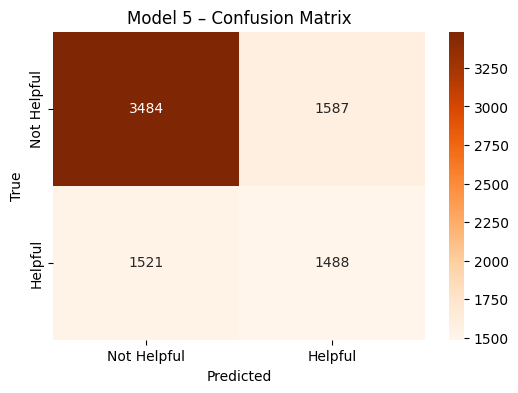

              precision    recall  f1-score   support

 Not Helpful       0.70      0.69      0.69      5071
     Helpful       0.48      0.49      0.49      3009

    accuracy                           0.62      8080
   macro avg       0.59      0.59      0.59      8080
weighted avg       0.62      0.62      0.62      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred_lstm5 = (model_lstm_glove_reg.predict(X_test) >= 0.5).astype(int).flatten()

# Confusion matrix
cm_lstm5 = confusion_matrix(y_test, y_pred_lstm5)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm5, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model 5 – Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_lstm5, target_names=['Not Helpful', 'Helpful']))


### 9.6 Model 6 – Confusion Matrix & Classification Report


253/253 [==============================] - 1s 3ms/step


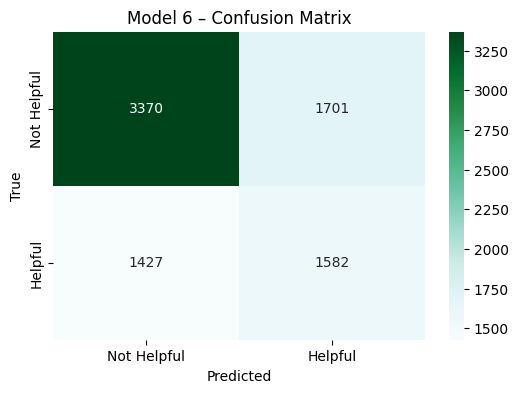

              precision    recall  f1-score   support

 Not Helpful       0.70      0.66      0.68      5071
     Helpful       0.48      0.53      0.50      3009

    accuracy                           0.61      8080
   macro avg       0.59      0.60      0.59      8080
weighted avg       0.62      0.61      0.62      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred_cnn = (cnn_model.predict(X_test) >= 0.5).astype(int).flatten()

# Confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model 6 – Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_cnn, target_names=['Not Helpful', 'Helpful']))


### 9.7 Model 7 – Confusion Matrix & Classification Report


In [ ]:
def bert_ds_to_numpy(ds):
  input_ids_list = []
  attention_mask_list = []
  labels_list = []

  for batch in ds.unbatch().as_numpy_iterator():
      inputs, labels = batch
      input_ids_list.append(inputs["input_ids"])
      attention_mask_list.append(inputs["attention_mask"])
      labels_list.append(labels)

  X_test = {
      "input_ids": np.stack(input_ids_list),
      "attention_mask": np.stack(attention_mask_list)
  }
  return X_test, np.array(labels_list)

253/253 ━━━━━━━━━━━━━━━━━━━━ 49s 181ms/step


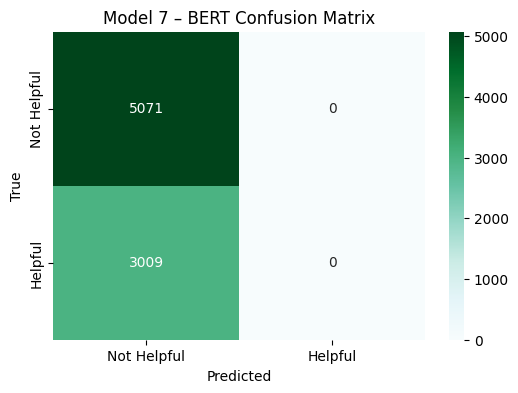

              precision    recall  f1-score   support

 Not Helpful       0.63      1.00      0.77      5071
     Helpful       0.00      0.00      0.00      3009

    accuracy                           0.63      8080
   macro avg       0.31      0.50      0.39      8080
weighted avg       0.39      0.63      0.48      8080



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

X_test, y_test = bert_ds_to_numpy(bert_test_ds)

# Predict probabilities → convert to binary labels
y_pred_bert = (BERT_model.predict(X_test) >= 0.5).astype(int).flatten()

# Confusion matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model 7 – BERT Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_bert, target_names=['Not Helpful', 'Helpful']))


### 9.8 Model 8 – Confusion Matrix & Classification Report


253/253 ━━━━━━━━━━━━━━━━━━━━ 52s 195ms/step


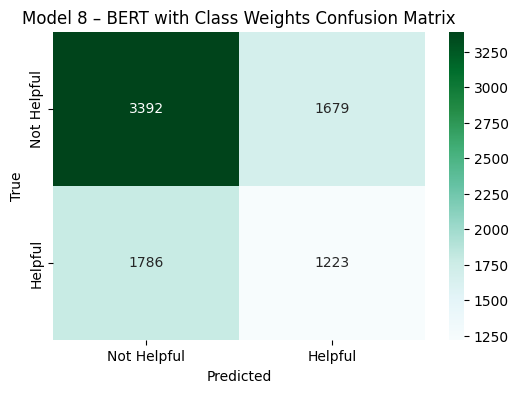

              precision    recall  f1-score   support

 Not Helpful       0.66      0.67      0.66      5071
     Helpful       0.42      0.41      0.41      3009

    accuracy                           0.57      8080
   macro avg       0.54      0.54      0.54      8080
weighted avg       0.57      0.57      0.57      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred_test = (bert_weighted_model.predict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}) >= 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(Labels_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model 8 – BERT with Class Weights Confusion Matrix')
plt.show()

# Classification report
print(classification_report(Labels_test, y_pred_test, target_names=['Not Helpful', 'Helpful']))


### 9.9 Model 9 – Confusion Matrix & Classification Report


253/253 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step


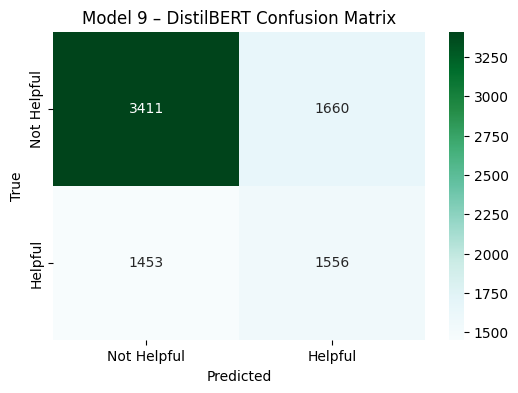

              precision    recall  f1-score   support

 Not Helpful       0.70      0.67      0.69      5071
     Helpful       0.48      0.52      0.50      3009

    accuracy                           0.61      8080
   macro avg       0.59      0.59      0.59      8080
weighted avg       0.62      0.61      0.62      8080



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

X_test, y_test = bert_ds_to_numpy(distilbert_test_ds)

# Step 1: Get predictions (sigmoid output for binary classification)
y_pred_prob_bert9 = distilbert_weighted_model.predict(X_test)

# Step 2: Convert probabilities to binary predictions
y_pred_bert9 = (y_pred_prob_bert9 >= 0.5).astype(int).flatten()

# Step 3: Confusion matrix
cm_bert9 = confusion_matrix(y_test, y_pred_bert9)

# Step 4: Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm_bert9, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Not Helpful', 'Helpful'],
            yticklabels=['Not Helpful', 'Helpful'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Model 9 – DistilBERT Confusion Matrix')
plt.show()

# Step 5: Classification report
print(classification_report(y_test, y_pred_bert9, target_names=['Not Helpful', 'Helpful']))


In this project, our goal was to build a model that predicts whether a product review is **helpful** (1) or **not helpful** (0) using deep learning architectures based on LSTM and CNN.

####  Understanding the Metrics

| Metric       | Simple Explanation                                                  | In This Project                                      |
|--------------|---------------------------------------------------------------------|------------------------------------------------------|
| **Recall**   | "Of all actually helpful reviews, how many did we catch?"           | Did the model find **most of the truly helpful** reviews? |
| **Precision**| "Of all reviews predicted as helpful, how many truly were helpful?" | Did the model avoid showing **unhelpful reviews as helpful**? |

###  Summary

- **Recall** = Coverage → did we catch the helpful ones?
- **Precision** = Trust → can we rely on what we predicted as helpful?

###  Comparative Confusion Matrix Summary

| Model                    | True Pos (TP) | False Neg (FN) | False Pos (FP) | True Neg (TN) |
|-------------------------|---------------|----------------|----------------|---------------|
| **Basic LSTM**           | 945           | 2064           | 865            | 4206          |
| **GloVe LSTM**           | 707           | 2302           | **569**        | **4502**      |
| **Regularized LSTM**     | **915**       | 2094           | 827            | 4244          |
| **Bidirectional LSTM**   | 870           | **2139**       | 858            | 4213          |
| **LSTM (Fine-Tuned GloVe)** | 1488       | 1521           | 1587           | 3484          |
| **CNN**                  | 1582          | 1427           | 1701           | 3370          |


###  Interpretation

- ✅ **GloVe LSTM** had the **lowest false positives (569)**, making it the most **precision-oriented**, though its recall was the weakest.
- ✅ **Regularized LSTM** achieved the **highest true positives (915)** and maintained a strong balance of recall and precision.
- ✅ **Bidirectional LSTM** performed comparably with a good Helpful F1-score (0.37), leveraging both forward and backward context.
- ✅ **LSTM with Fine-Tuned GloVe (Model 5)** significantly improved on minority class detection with a Helpful F1-score of 0.49.
- ✅ **CNN (Model 6)** achieved the **highest Helpful recall (0.53)** and **F1-score (0.50)**, outperforming all other models in Helpful class performance.

### Final Comparison Insight

The **Regularized LSTM model** (Model 3) delivered strong, balanced results using dropout and L2 regularization, while the **Bidirectional LSTM** (Model 4) effectively captured sequence-level context.

However, the **LSTM with Fine-Tuned GloVe** and especially the **CNN model** demonstrated superior ability to detect helpful reviews — with Model 6 outperforming all others in both Helpful recall and F1-score.

These results show that **carefully engineered training strategies** — including class weighting, fine-tuning, dropout, and alternative architectures like CNN — can substantially improve detection of minority classes. In real-world applications, these models offer a more **trustworthy and practical solution** for highlighting truly helpful content.

